# 一、PPO

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical, Normal
from IPython.display import clear_output

# 假設環境的狀態維度與動作空間
STATE_DIM = 4       # 例如CartPole環境的狀態維度
ACTION_DIM = 2      # 例如CartPole環境的離散動作個數
# 若為連續動作，則可設定ACTION_DIM為動作維度

# 超參數設定
HIDDEN_SIZE = 64
LEARNING_RATE = 3e-4
EPSILON_CLIP = 0.2
GAMMA = 0.99
BATCH_SIZE = 64
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 策略網路（Actor）定義（此處以離散動作為例）
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.action_head = nn.Linear(hidden_size, action_dim)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        action_logits = self.action_head(x)
        return F.softmax(action_logits, dim=-1)
    
    def get_action(self, state):
        state = torch.FloatTensor(state).to(device)
        probs = self.forward(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

# 價值網路（Critic）定義
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.state_value = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        value = self.state_value(x)
        return value

# PPO Agent 整合 Actor 與 Critic
class PPOAgent:
    def __init__(self, state_dim, action_dim, hidden_size, lr, epsilon_clip, gamma):
        self.actor = Actor(state_dim, action_dim, hidden_size).to(device)
        self.critic = Critic(state_dim, hidden_size).to(device)
        self.optimizer = optim.Adam(list(self.actor.parameters()) + list(self.critic.parameters()), lr=lr)
        self.epsilon_clip = epsilon_clip
        self.gamma = gamma

    def compute_advantages(self, rewards, values, next_values, dones):
        advantages = []
        gae = 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * next_values[i] * (1 - dones[i]) - values[i]
            gae = delta + self.gamma * 0.95 * (1 - dones[i]) * gae  # 0.95為lambda，亦可設置為超參數
            advantages.insert(0, gae)
        return advantages

    def update(self, trajectories):
        # trajectories 為字典，包含以下 keys：
        # 'states', 'actions', 'log_probs', 'rewards', 'next_states', 'dones'
        states = torch.FloatTensor(trajectories['states']).to(device)
        actions = torch.LongTensor(trajectories['actions']).to(device)
        old_log_probs = torch.FloatTensor(trajectories['log_probs']).to(device)
        rewards = trajectories['rewards']
        dones = trajectories['dones']

        # 計算當前狀態值估計
        values = self.critic(states).squeeze().detach().cpu().numpy()
        # 計算 next_states 的價值
        next_states = torch.FloatTensor(trajectories['next_states']).to(device)
        next_values = self.critic(next_states).squeeze().detach().cpu().numpy()

        # 計算 advantage 值
        advantages = self.compute_advantages(rewards, values, next_values, dones)
        advantages = torch.FloatTensor(advantages).to(device)
        # 計算折扣回報（targets）
        targets = advantages + torch.FloatTensor(values).to(device)

        # 執行多次 epochs 的更新
        dataset_size = states.size(0)
        for _ in range(EPOCHS):
            for idx in range(0, dataset_size, BATCH_SIZE):
                batch_slice = slice(idx, min(idx+BATCH_SIZE, dataset_size))
                batch_states = states[batch_slice]
                batch_actions = actions[batch_slice]
                batch_old_log_probs = old_log_probs[batch_slice]
                batch_advantages = advantages[batch_slice]
                batch_targets = targets[batch_slice]

                # 取得目前策略的機率與log_prob
                probs = self.actor(batch_states)
                dist = Categorical(probs)
                new_log_probs = dist.log_prob(batch_actions)
                
                # 計算重要性比值
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                # PPO剪裁目標函數
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.epsilon_clip, 1 + self.epsilon_clip) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # Critic loss 使用均方誤差
                values_pred = self.critic(batch_states).squeeze()
                critic_loss = F.mse_loss(values_pred, batch_targets)
                
                # 總損失
                loss = actor_loss + 0.5 * critic_loss  # 0.5為價值函數損失的權重，可調整

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def select_action(self, state):
        action, log_prob = self.actor.get_action(state)
        return action, log_prob.item()

# 範例：使用 PPOAgent 與模擬環境進行互動（此處僅為示意）
if __name__ == '__main__':
    try:
        import gym
        env = gym.make('CartPole-v1')
        agent = PPOAgent(STATE_DIM, ACTION_DIM, HIDDEN_SIZE, LEARNING_RATE, EPSILON_CLIP, GAMMA)
        
        num_episodes = 1000
        max_steps = 500

        for episode in range(num_episodes):
            state, _ = env.reset()
            trajectories = {'states': [], 'actions': [], 'log_probs': [],
                            'rewards': [], 'next_states': [], 'dones': []}
            episode_reward = 0

            for step in range(max_steps):
                action, log_prob = agent.select_action(state)
                next_state, reward, done, _, _ = env.step(action)
                episode_reward += reward

                trajectories['states'].append(state)
                trajectories['actions'].append(action)
                trajectories['log_probs'].append(log_prob)
                trajectories['rewards'].append(reward)
                trajectories['next_states'].append(next_state)
                trajectories['dones'].append(float(done))

                state = next_state
                if done:
                    break

            # 更新 agent
            agent.update(trajectories)
            if (episode + 1) % 20 == 0:
                clear_output()
                print(f"Episode {episode+1}: Reward = {episode_reward}")
    except KeyboardInterrupt:
        pass            


Episode 20: Reward = 19.0


c:\Users\jhbai\Anaconda\envs\MachineLearningEnv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


GIF 已保存為 cartpole.gif


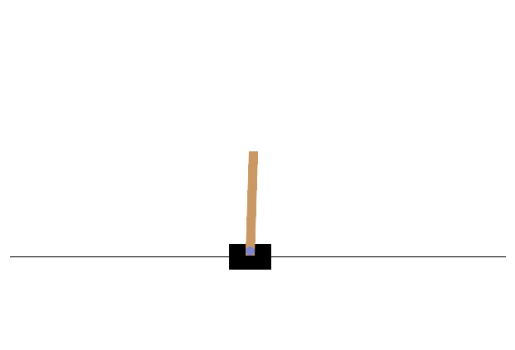

In [3]:
import gym
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter, FuncAnimation
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 建立環境
ENV = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = ENV.reset()
frames = []  # 用於存儲每個畫面

# 遊戲過程
done = False
for f in range(100):
    action, log_prob = agent.select_action(state)
    state, reward, done, _, _ = ENV.step(action)
    frame = ENV.render()  # 獲取畫面陣列
    frames.append(frame)  # 儲存畫面

ENV.close()

# 創建 GIF
fig, ax = plt.subplots()
ax.axis('off')  # 關閉座標軸
img = ax.imshow(frames[0])  # 初始化第一幀

# 更新每幀的函數
def update(frame):
    img.set_data(frame)
    return [img]

# 使用 matplotlib.animation 生成動畫
ani = FuncAnimation(
    fig, update, frames=frames, interval=50, blit=True  # interval: 控制幀率
)

# 將動畫保存為 GIF
ani.save("cartpole.gif", writer=PillowWriter(fps=20))  # fps: 每秒幀數
print("GIF 已保存為 cartpole.gif")

# 二、CPD

使用的設備：cuda


Epoch 1/20: 100%|██████████| 32/32 [00:00<00:00, 57.89it/s]


Epoch 1 Loss: 0.4643


Epoch 2/20: 100%|██████████| 32/32 [00:00<00:00, 111.83it/s]


Epoch 2 Loss: 0.3458


Epoch 3/20: 100%|██████████| 32/32 [00:00<00:00, 259.08it/s]


Epoch 3 Loss: 0.2749


Epoch 4/20: 100%|██████████| 32/32 [00:00<00:00, 355.35it/s]


Epoch 4 Loss: 0.2183


Epoch 5/20: 100%|██████████| 32/32 [00:00<00:00, 325.22it/s]


Epoch 5 Loss: 0.1724


Epoch 6/20: 100%|██████████| 32/32 [00:00<00:00, 337.26it/s]


Epoch 6 Loss: 0.1377


Epoch 7/20: 100%|██████████| 32/32 [00:00<00:00, 283.47it/s]


Epoch 7 Loss: 0.1105


Epoch 8/20: 100%|██████████| 32/32 [00:00<00:00, 328.90it/s]


Epoch 8 Loss: 0.0907


Epoch 9/20: 100%|██████████| 32/32 [00:00<00:00, 326.47it/s]


Epoch 9 Loss: 0.0754


Epoch 10/20: 100%|██████████| 32/32 [00:00<00:00, 340.11it/s]


Epoch 10 Loss: 0.0640


Epoch 11/20: 100%|██████████| 32/32 [00:00<00:00, 339.28it/s]


Epoch 11 Loss: 0.0546


Epoch 12/20: 100%|██████████| 32/32 [00:00<00:00, 326.33it/s]


Epoch 12 Loss: 0.0477


Epoch 13/20: 100%|██████████| 32/32 [00:00<00:00, 371.37it/s]


Epoch 13 Loss: 0.0423


Epoch 14/20: 100%|██████████| 32/32 [00:00<00:00, 264.25it/s]


Epoch 14 Loss: 0.0374


Epoch 15/20: 100%|██████████| 32/32 [00:00<00:00, 299.52it/s]


Epoch 15 Loss: 0.0339


Epoch 16/20: 100%|██████████| 32/32 [00:00<00:00, 353.54it/s]


Epoch 16 Loss: 0.0308


Epoch 17/20: 100%|██████████| 32/32 [00:00<00:00, 309.14it/s]


Epoch 17 Loss: 0.0284


Epoch 18/20: 100%|██████████| 32/32 [00:00<00:00, 369.90it/s]


Epoch 18 Loss: 0.0263


Epoch 19/20: 100%|██████████| 32/32 [00:00<00:00, 367.63it/s]


Epoch 19 Loss: 0.0245


Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 380.50it/s]


Epoch 20 Loss: 0.0229


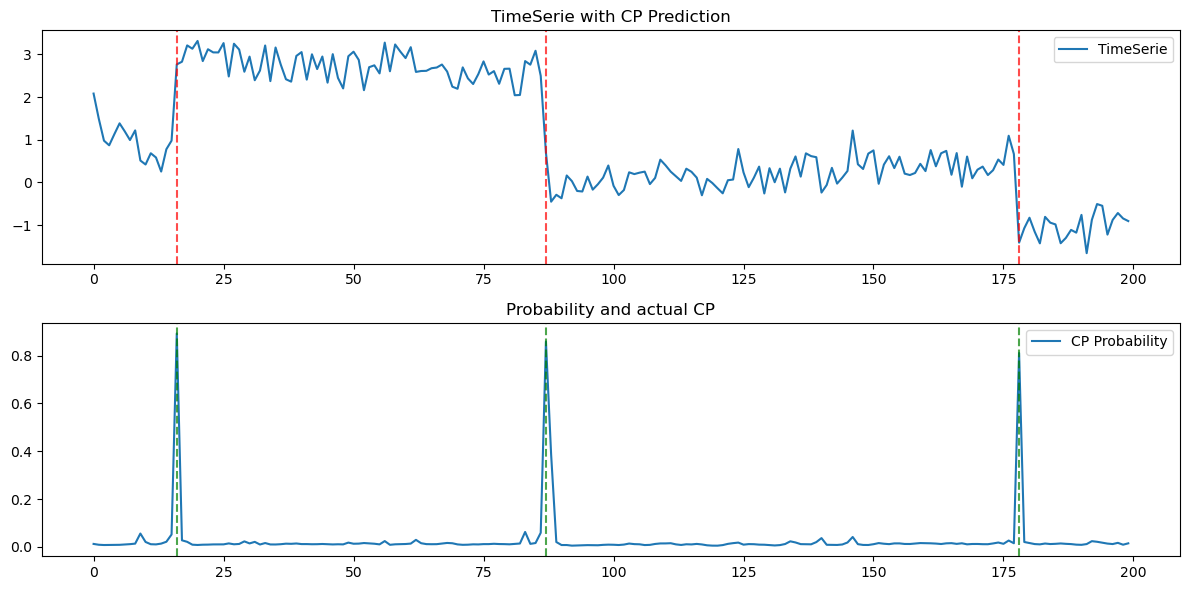

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 設定隨機種子，確保結果可重現
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# ==========================
# 1. 資料生成與Dataset定義
# ==========================

def generate_sample(seq_length=200, min_breakpoints=1, max_breakpoints=3):
    """
    隨機產生一筆時間序列資料，包含隨機數量的斷點。
    每段資料由一個線性函數生成，並加入雜訊。
    
    輸出：
        x: shape = (seq_length, ) 的浮點數陣列，為時間序列數值
        y: shape = (seq_length, ) 的二元標籤，1 代表斷點（段落起點），0 代表非斷點
    """
    # 隨機決定斷點數量
    n_breakpoints = random.randint(min_breakpoints, max_breakpoints)
    # 隨機選擇斷點位置（不含首尾）
    possible_points = list(range(10, seq_length - 10))
    breakpoints = sorted(random.sample(possible_points, n_breakpoints))
    
    # 將起始點也當作段落開始，但不標記為斷點（通常不視為變化點）
    segment_starts = [0] + breakpoints
    segment_ends = breakpoints + [seq_length]
    
    x = np.zeros(seq_length)
    y = np.zeros(seq_length)  # 斷點標籤：除了第一個位置，其餘段落起點標記為 1
    
    for start, end in zip(segment_starts, segment_ends):
        # 隨機決定本段的線性參數
        slope = np.random.uniform(-1, 1)
        intercept = np.random.uniform(-5, 5)
        # 產生線性資料，再加入隨機雜訊
        segment_length = end - start
        t = np.linspace(0, 1, segment_length)
        segment_data = slope * t + intercept + np.random.normal(0, 0.3, size=segment_length)
        x[start:end] = segment_data
        
    # 將斷點標記為 1（將每段的起點（除第一段）標記為斷點）
    for pt in segment_starts[1:]:
        y[pt] = 1.0
        
    return x.astype(np.float32), y.astype(np.float32)

class ChangePointDataset(Dataset):
    """
    定義一個自訂 Dataset，生成多筆含有斷點標記的時間序列資料
    """
    def __init__(self, n_samples=1000, seq_length=200):
        self.n_samples = n_samples
        self.seq_length = seq_length
        self.data = []
        self.labels = []
        for _ in range(n_samples):
            x, y = generate_sample(seq_length=seq_length)
            self.data.append(x)
            self.labels.append(y)
        self.data = np.array(self.data)    # shape = (n_samples, seq_length)
        self.labels = np.array(self.labels)  # shape = (n_samples, seq_length)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        # 輸出 shape: (1, seq_length) － 增加 channel 維度
        sample = torch.tensor(self.data[idx]).unsqueeze(0)
        label = torch.tensor(self.labels[idx])
        return sample, label

# ==========================
# 2. 建立神經網路模型
# ==========================
class CNNChangePointDetector(nn.Module):
    def __init__(self):
        super(CNNChangePointDetector, self).__init__()
        # 利用 1D 卷積網路來提取序列特徵
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm1d(16)
        self.relu3 = nn.ReLU()
        
        # 最後利用卷積層輸出一個通道，其長度與輸入一致
        self.conv_out = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=1)
        
    def forward(self, x):
        # x 的 shape: [batch, 1, seq_length]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.conv_out(x)
        # 輸出 shape: [batch, 1, seq_length] -> squeeze channel 維度
        x = x.squeeze(1)  # shape: [batch, seq_length]
        return x

# ==========================
# 3. 訓練設定與訓練流程
# ==========================
def train_model(model, dataloader, criterion, optimizer, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)      # shape: [batch, 1, seq_length]
            labels = labels.to(device)      # shape: [batch, seq_length]
            
            optimizer.zero_grad()
            outputs = model(inputs)         # shape: [batch, seq_length]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")
    return model

# ==========================
# 4. 模型預測與結果展示
# ==========================
def predict_and_plot(model, dataset, device, index=0, threshold=0.5):
    """
    取出 dataset 中第 index 筆資料進行預測，並展示原始序列、預測斷點與實際斷點
    """
    model.eval()
    sample, label = dataset[index]
    sample = sample.unsqueeze(0).to(device)  # shape: [1, 1, seq_length]
    with torch.no_grad():
        output = model(sample)   # shape: [1, seq_length]
        output = output.squeeze(0).cpu().numpy()
    # 將 logits 輸出轉換為機率
    prob = 1 / (1 + np.exp(-output))
    
    # 根據門檻決定斷點
    pred_breakpoints = (prob > threshold).astype(int)
    
    seq = sample.squeeze().cpu().numpy()
    t = np.arange(len(seq))
    
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, seq, label="TimeSerie")
    # 標出預測的斷點位置
    pred_indices = np.where(pred_breakpoints==1)[0]
    for idx in pred_indices:
        plt.axvline(x=idx, color='r', linestyle='--', alpha=0.7)
    plt.title("TimeSerie with CP Prediction")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(t, prob, label="CP Probability")
    # 標出實際的斷點位置
    true_indices = np.where(label.numpy()==1)[0]
    for idx in true_indices:
        plt.axvline(x=idx, color='g', linestyle='--', alpha=0.7)
    plt.title("Probability and actual CP")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==========================
# 5. 主程式
# ==========================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用的設備：{device}")
    
    # 建立訓練資料集與 DataLoader
    train_dataset = ChangePointDataset(n_samples=1000, seq_length=200)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # 建立模型、損失函數與優化器
    model = CNNChangePointDetector().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 訓練模型
    trained_model = train_model(model, train_loader, criterion, optimizer, device, num_epochs=20)
    
    # 測試模型：隨機取一筆測試資料展示結果
    test_dataset = ChangePointDataset(n_samples=1000, seq_length=200)
    predict_and_plot(trained_model, test_dataset, device, index=random.randint(0, len(test_dataset)-1))

if __name__ == '__main__':
    main()


# 三、Deep Retrieval + Universial Approximate Theorem

使用的設備：cuda


Epoch 1/20: 100%|██████████| 32/32 [00:00<00:00, 60.86it/s]


Epoch 1 Total Loss: 0.5355 | Det Loss: 0.4240 | Err Loss: 0.0083


Epoch 2/20: 100%|██████████| 32/32 [00:00<00:00, 121.75it/s]


Epoch 2 Total Loss: 0.3828 | Det Loss: 0.3397 | Err Loss: 0.0062


Epoch 3/20: 100%|██████████| 32/32 [00:00<00:00, 123.63it/s]


Epoch 3 Total Loss: 0.2969 | Det Loss: 0.2655 | Err Loss: 0.0039


Epoch 4/20: 100%|██████████| 32/32 [00:00<00:00, 250.90it/s]


Epoch 4 Total Loss: 0.2336 | Det Loss: 0.2108 | Err Loss: 0.0059


Epoch 5/20: 100%|██████████| 32/32 [00:00<00:00, 281.79it/s]


Epoch 5 Total Loss: 0.1861 | Det Loss: 0.1635 | Err Loss: 0.0036


Epoch 6/20: 100%|██████████| 32/32 [00:00<00:00, 327.52it/s]


Epoch 6 Total Loss: 0.1505 | Det Loss: 0.1267 | Err Loss: 0.0025


Epoch 7/20: 100%|██████████| 32/32 [00:00<00:00, 337.77it/s]


Epoch 7 Total Loss: 0.1232 | Det Loss: 0.1077 | Err Loss: 0.0041


Epoch 8/20: 100%|██████████| 32/32 [00:00<00:00, 304.85it/s]


Epoch 8 Total Loss: 0.1019 | Det Loss: 0.0851 | Err Loss: 0.0027


Epoch 9/20: 100%|██████████| 32/32 [00:00<00:00, 285.13it/s]


Epoch 9 Total Loss: 0.0858 | Det Loss: 0.0747 | Err Loss: 0.0037


Epoch 10/20: 100%|██████████| 32/32 [00:00<00:00, 323.13it/s]


Epoch 10 Total Loss: 0.0733 | Det Loss: 0.0718 | Err Loss: 0.0041


Epoch 11/20: 100%|██████████| 32/32 [00:00<00:00, 302.67it/s]


Epoch 11 Total Loss: 0.0638 | Det Loss: 0.0552 | Err Loss: 0.0031


Epoch 12/20: 100%|██████████| 32/32 [00:00<00:00, 309.34it/s]


Epoch 12 Total Loss: 0.0562 | Det Loss: 0.0505 | Err Loss: 0.0030


Epoch 13/20: 100%|██████████| 32/32 [00:00<00:00, 327.69it/s]


Epoch 13 Total Loss: 0.0502 | Det Loss: 0.0465 | Err Loss: 0.0034


Epoch 14/20: 100%|██████████| 32/32 [00:00<00:00, 326.11it/s]


Epoch 14 Total Loss: 0.0451 | Det Loss: 0.0392 | Err Loss: 0.0028


Epoch 15/20: 100%|██████████| 32/32 [00:00<00:00, 330.32it/s]


Epoch 15 Total Loss: 0.0411 | Det Loss: 0.0421 | Err Loss: 0.0043


Epoch 16/20: 100%|██████████| 32/32 [00:00<00:00, 294.69it/s]


Epoch 16 Total Loss: 0.0378 | Det Loss: 0.0352 | Err Loss: 0.0032


Epoch 17/20: 100%|██████████| 32/32 [00:00<00:00, 321.50it/s]


Epoch 17 Total Loss: 0.0349 | Det Loss: 0.0332 | Err Loss: 0.0031


Epoch 18/20: 100%|██████████| 32/32 [00:00<00:00, 332.74it/s]


Epoch 18 Total Loss: 0.0324 | Det Loss: 0.0265 | Err Loss: 0.0023


Epoch 19/20: 100%|██████████| 32/32 [00:00<00:00, 291.65it/s]


Epoch 19 Total Loss: 0.0306 | Det Loss: 0.0275 | Err Loss: 0.0026


Epoch 20/20: 100%|██████████| 32/32 [00:00<00:00, 323.64it/s]


Epoch 20 Total Loss: 0.0287 | Det Loss: 0.0241 | Err Loss: 0.0025


C:\Users\jhbai\AppData\Local\Temp\ipykernel_58100\2577250815.py:235: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\jhbai\AppData\Local\Temp\ipykernel_58100\2577250815.py:235: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\jhbai\AppData\Local\Temp\ipykernel_58100\2577250815.py:235: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  plt.tight_layout()
C:\Users\jhbai\AppData\Local\Temp\ipykernel_58100\2577250815.py:235: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from current font.
  plt.tight_layout()
C:\Users\jhbai\AppData\Local\Temp\ipykernel_58100\2577250815.py:235: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from current font.
  plt.tight_layout()
C:\Users\jhbai\AppData\Local\Temp\ipykernel_58100\2577250815.py:235: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}

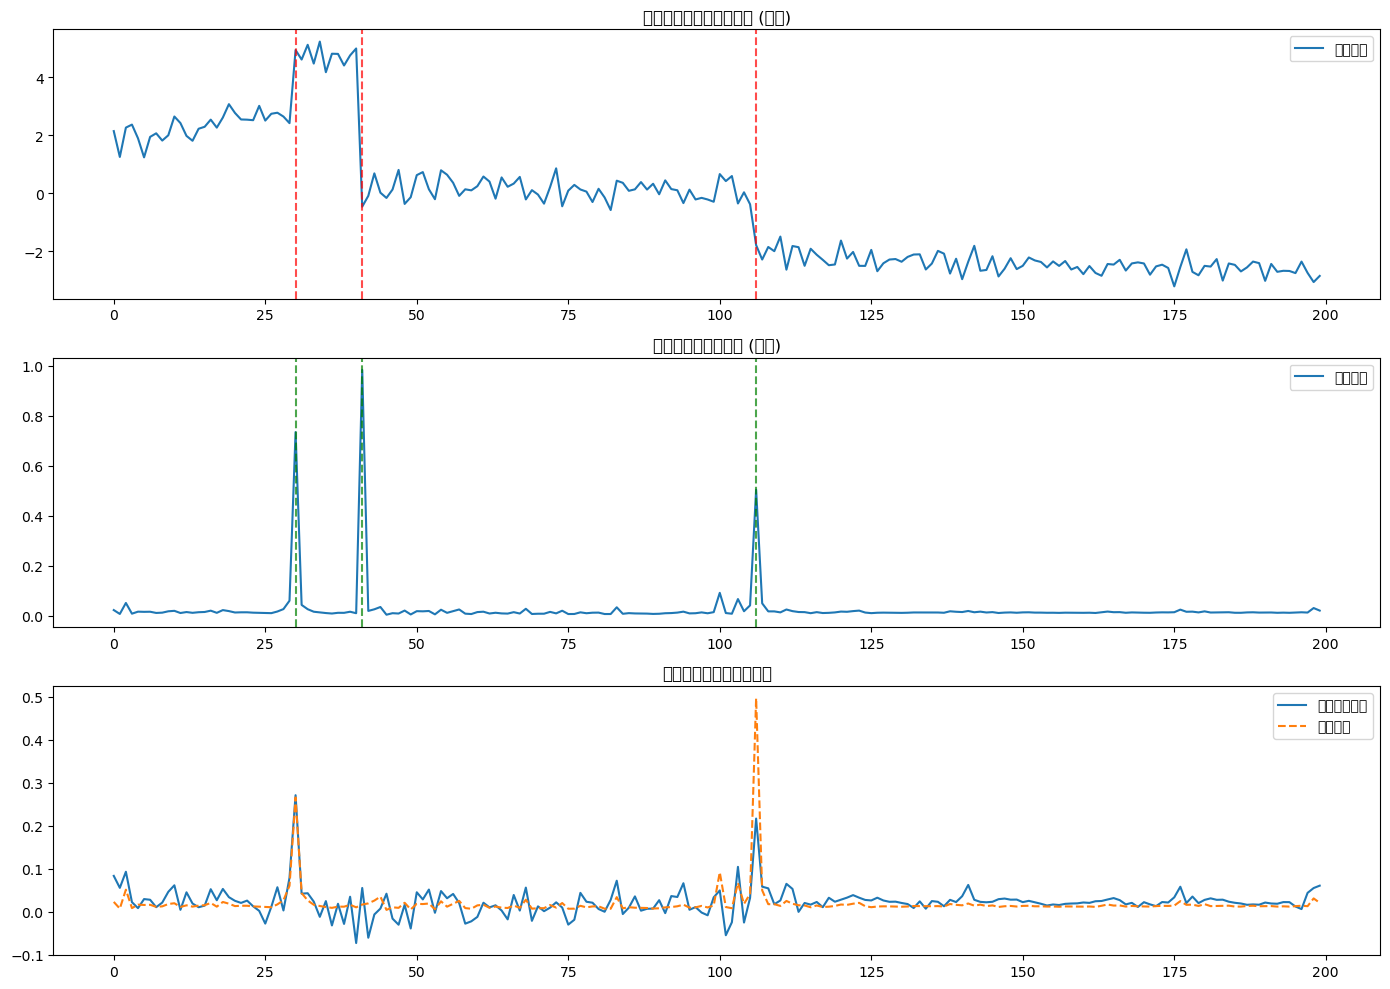

In [3]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 設定隨機種子，確保結果可重現
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# ==========================
# 1. 資料生成與 Dataset 定義
# ==========================
def generate_sample(seq_length=200, min_breakpoints=1, max_breakpoints=3):
    """
    隨機產生一筆時間序列資料，包含隨機數量的斷點。
    每段資料由一個線性函數生成，並加入雜訊。
    
    輸出：
        x: (seq_length,) 浮點數陣列，為時間序列資料
        y: (seq_length,) 二元標籤，標記段落起點（斷點），第一點不標記
    """
    # 隨機決定斷點數量
    n_breakpoints = random.randint(min_breakpoints, max_breakpoints)
    # 隨機選擇斷點位置（避免太靠近序列起始或結尾）
    possible_points = list(range(10, seq_length - 10))
    breakpoints = sorted(random.sample(possible_points, n_breakpoints))
    
    # 將起始點也當作段落開始，但不標記為斷點
    segment_starts = [0] + breakpoints
    segment_ends = breakpoints + [seq_length]
    
    x = np.zeros(seq_length)
    y = np.zeros(seq_length)  # 斷點標籤：除第一點外，每段起點標記為 1
    
    for start, end in zip(segment_starts, segment_ends):
        # 隨機決定本段的線性參數
        slope = np.random.uniform(-1, 1)
        intercept = np.random.uniform(-5, 5)
        segment_length = end - start
        t = np.linspace(0, 1, segment_length)
        segment_data = slope * t + intercept + np.random.normal(0, 0.3, size=segment_length)
        x[start:end] = segment_data
        
    # 標記斷點（除第一段外）
    for pt in segment_starts[1:]:
        y[pt] = 1.0
        
    return x.astype(np.float32), y.astype(np.float32)

class ChangePointDataset(Dataset):
    """
    自訂 Dataset：生成多筆含有斷點標記的時間序列資料
    """
    def __init__(self, n_samples=1000, seq_length=200):
        self.n_samples = n_samples
        self.seq_length = seq_length
        self.data = []
        self.labels = []
        for _ in range(n_samples):
            x, y = generate_sample(seq_length=seq_length)
            self.data.append(x)
            self.labels.append(y)
        self.data = np.array(self.data)    # (n_samples, seq_length)
        self.labels = np.array(self.labels)  # (n_samples, seq_length)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        # 增加 channel 維度，輸出形狀 (1, seq_length)
        sample = torch.tensor(self.data[idx]).unsqueeze(0)
        label = torch.tensor(self.labels[idx])
        return sample, label

# ==========================
# 2. 建立多任務神經網路模型
# ==========================
class MultiTaskChangePointDetector(nn.Module):
    def __init__(self):
        super(MultiTaskChangePointDetector, self).__init__()
        # 共用特徵提取層（Backbone）
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(32)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm1d(16)
        self.relu3 = nn.ReLU()
        
        # Detection Head：斷點預測，輸出與輸入長度相同的 logits
        self.det_head = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=1)
        
        # Retrieval (Error) Head：額外輸出預測誤差
        self.err_head = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=1)
        
    def forward(self, x):
        # x: [batch, 1, seq_length]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        # 取得共用特徵（shape: [batch, 16, seq_length]）
        features = x
        
        # Detection 分支：斷點偵測
        det_out = self.det_head(features)  # shape: [batch, 1, seq_length]
        det_out = det_out.squeeze(1)        # shape: [batch, seq_length]
        
        # Retrieval 分支：預測誤差
        err_out = self.err_head(features)   # shape: [batch, 1, seq_length]
        err_out = err_out.squeeze(1)         # shape: [batch, seq_length]
        
        return det_out, err_out

# ==========================
# 3. 訓練流程與損失函數設定
# ==========================
def train_model(model, dataloader, criterion_det, criterion_err, optimizer, device, num_epochs=20, lambda_err=1.0):
    """
    model: 多任務模型
    criterion_det: 斷點偵測損失 (BCEWithLogitsLoss)
    criterion_err: 誤差檢索損失 (MSELoss)
    lambda_err: 誤差分支損失權重
    """
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)   # [batch, 1, seq_length]
            labels = labels.to(device)   # [batch, seq_length]
            
            optimizer.zero_grad()
            det_out, err_out = model(inputs)   # det_out 為斷點 logits，err_out 為預測誤差
            
            # 損失1：斷點偵測損失 (直接用 BCEWithLogitsLoss)
            loss_det = criterion_det(det_out, labels)
            
            # 由 det_out 計算預測機率，但不反向傳遞梯度到 detection branch (detach)
            with torch.no_grad():
                prob_det = torch.sigmoid(det_out)
                # 使用絕對誤差作為「真實誤差」，此處可視為 false positive/false negative 的程度
                true_err = torch.abs(labels - prob_det)
            
            # 損失2：誤差檢索損失，採用 MSELoss
            loss_err = criterion_err(err_out, true_err)
            
            # 總損失：兩部分損失加權和
            loss = loss_det + lambda_err * loss_err
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1} Total Loss: {epoch_loss:.4f} | Det Loss: {loss_det.item():.4f} | Err Loss: {loss_err.item():.4f}")
    return model

# ==========================
# 4. 模型預測與結果展示
# ==========================
def predict_and_plot(model, dataset, device, index=0, threshold=0.5):
    """
    對 dataset 中第 index 筆資料進行預測，展示：
    － 原始時間序列
    － 斷點預測機率與預測斷點位置
    － 模型預測的誤差指標
    """
    model.eval()
    sample, label = dataset[index]
    sample = sample.unsqueeze(0).to(device)  # [1, 1, seq_length]
    with torch.no_grad():
        det_out, err_out = model(sample)   # 兩個分支的輸出
        det_out = det_out.squeeze(0).cpu().numpy()   # [seq_length]
        err_out = err_out.squeeze(0).cpu().numpy()   # [seq_length]
    # 將 logits 轉換為機率
    prob = 1 / (1 + np.exp(-det_out))
    
    # 根據門檻決定斷點位置
    pred_breakpoints = (prob > threshold).astype(int)
    
    seq = sample.squeeze().cpu().numpy()
    t = np.arange(len(seq))
    
    plt.figure(figsize=(14, 10))
    
    # 子圖 1：原始時間序列與斷點預測（紅線）
    plt.subplot(3, 1, 1)
    plt.plot(t, seq, label="時間序列")
    pred_indices = np.where(pred_breakpoints==1)[0]
    for idx in pred_indices:
        plt.axvline(x=idx, color='r', linestyle='--', alpha=0.7)
    plt.title("原始時間序列與預測斷點 (紅線)")
    plt.legend()
    
    # 子圖 2：斷點預測機率與實際斷點 (綠線)
    plt.subplot(3, 1, 2)
    plt.plot(t, prob, label="斷點機率")
    true_indices = np.where(label.numpy()==1)[0]
    for idx in true_indices:
        plt.axvline(x=idx, color='g', linestyle='--', alpha=0.7)
    plt.title("斷點機率與實際斷點 (綠線)")
    plt.legend()
    
    # 子圖 3：模型預測的誤差指標
    plt.subplot(3, 1, 3)
    plt.plot(t, err_out, label="預測誤差指標")
    # 可同時繪出真實誤差（使用預測機率與真實標籤的絕對差值）
    true_err = np.abs(label.numpy() - prob)
    plt.plot(t, true_err, label="真實誤差", linestyle='--')
    plt.title("模型預測誤差與真實誤差")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# ==========================
# 5. 主程式
# ==========================
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用的設備：{device}")
    
    # 建立資料集與 DataLoader
    train_dataset = ChangePointDataset(n_samples=1000, seq_length=200)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # 建立多任務模型
    model = MultiTaskChangePointDetector().to(device)
    
    # 定義損失函數：斷點偵測採用 BCEWithLogitsLoss；誤差檢索採用 MSELoss
    criterion_det = nn.BCEWithLogitsLoss()
    criterion_err = nn.MSELoss()
    
    # 建立優化器
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 訓練模型，lambda_err 可根據需求調整誤差分支損失權重
    trained_model = train_model(model, train_loader, criterion_det, criterion_err, optimizer, device, num_epochs=20, lambda_err=1.0)
    
    # 隨機取一筆資料展示預測結果
    test_idx = random.randint(0, len(train_dataset)-1)
    predict_and_plot(trained_model, train_dataset, device, index=test_idx, threshold=0.5)

if __name__ == '__main__':
    main()


# 四、替代DTW，改為Matrix Profile做異常檢測 (包含多尺度Pattern)

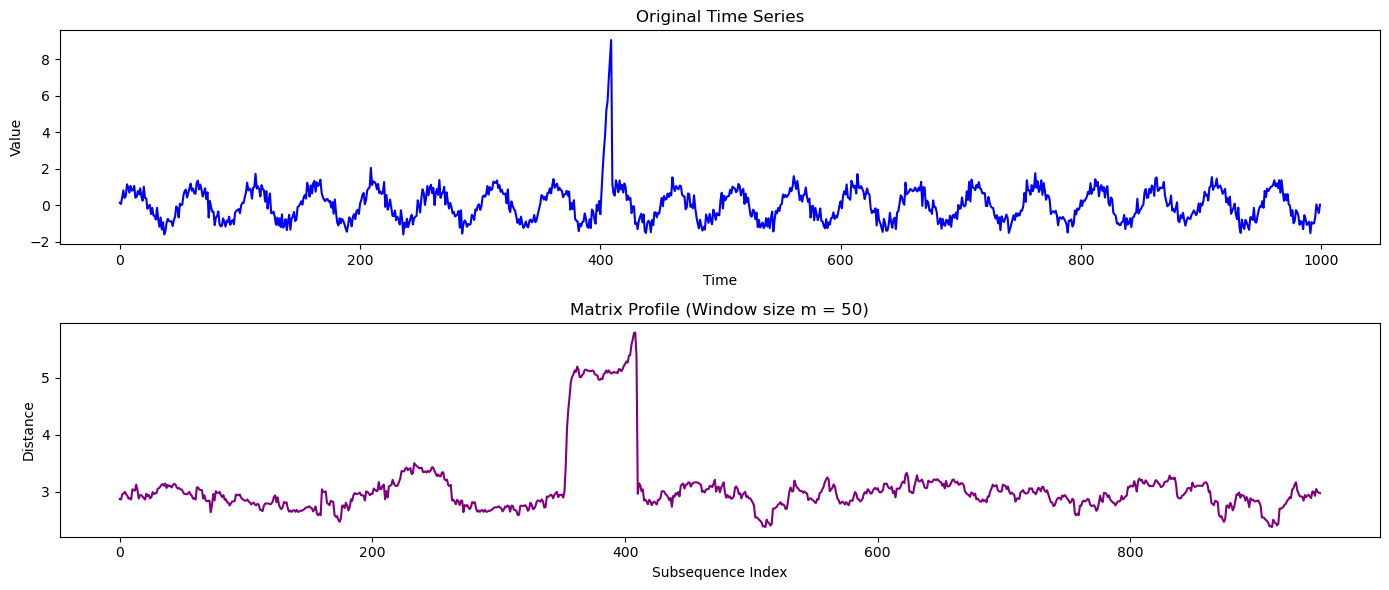

Motif indices (approx.): [156 157 159 170 171 172 173 174 175 315 316 503 504 505 506 507 508 509
 510 511 512 513 514 515 516 756 757 759 870 871 872 873 874 875 904 905
 906 907 908 909 910 911 912 913 914 915 916 917]
Discord indices (approx.): [358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 404 405 406 407 408 409]


In [ ]:
# -*- coding: utf-8 -*-
"""
Matrix Profile anomaly detection for a single scale using STUMPY.
This code computes the matrix profile for a given time series and window size (m),
then identifies motifs (low distance) and discords (high distance).
"""

import numpy as np
import matplotlib.pyplot as plt
import stumpy

# 產生模擬時間序列資料（例如正弦波加上隨機雜訊，再注入異常）
np.random.seed(42)
N = 1000                   # 總資料點數
time = np.arange(N)
data = np.sin(2 * np.pi * time / 50) + 0.3 * np.random.randn(N)
# 注入異常 (例如在位置400和700處)
for pos in [400]:
    if pos + 10 < N:
        data[pos:pos+10] += np.linspace(0, 8, 10)

# 設定窗口大小（尺度 m）
m = 50

# 使用 stumpy 計算 Matrix Profile
mp = stumpy.stump(data, m=m)
matrix_profile = mp[:, 0]  # 第一列為距離值
profile_index = mp[:, 1].astype(int)  # 第二列為最近鄰索引

# 畫出 Matrix Profile 與原始時間序列
plt.figure(figsize=(14, 6))
plt.subplot(211)
plt.plot(time, data, color='blue')
plt.title("Original Time Series")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(212)
plt.plot(np.arange(len(matrix_profile)), matrix_profile, color='purple')
plt.title("Matrix Profile (Window size m = {})".format(m))
plt.xlabel("Subsequence Index")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# 根據 Matrix Profile 判定 motifs 與 discords：
# 例如：低於某個百分位數（如 5% 分位數）判為 motif，高於 95% 分位數判為 discord
motif_threshold = np.percentile(matrix_profile, 5)
discord_threshold = np.percentile(matrix_profile, 95)

motif_indices = np.where(matrix_profile <= motif_threshold)[0]
discord_indices = np.where(matrix_profile >= discord_threshold)[0]

print("Motif indices (approx.):", motif_indices)
print("Discord indices (approx.):", discord_indices)


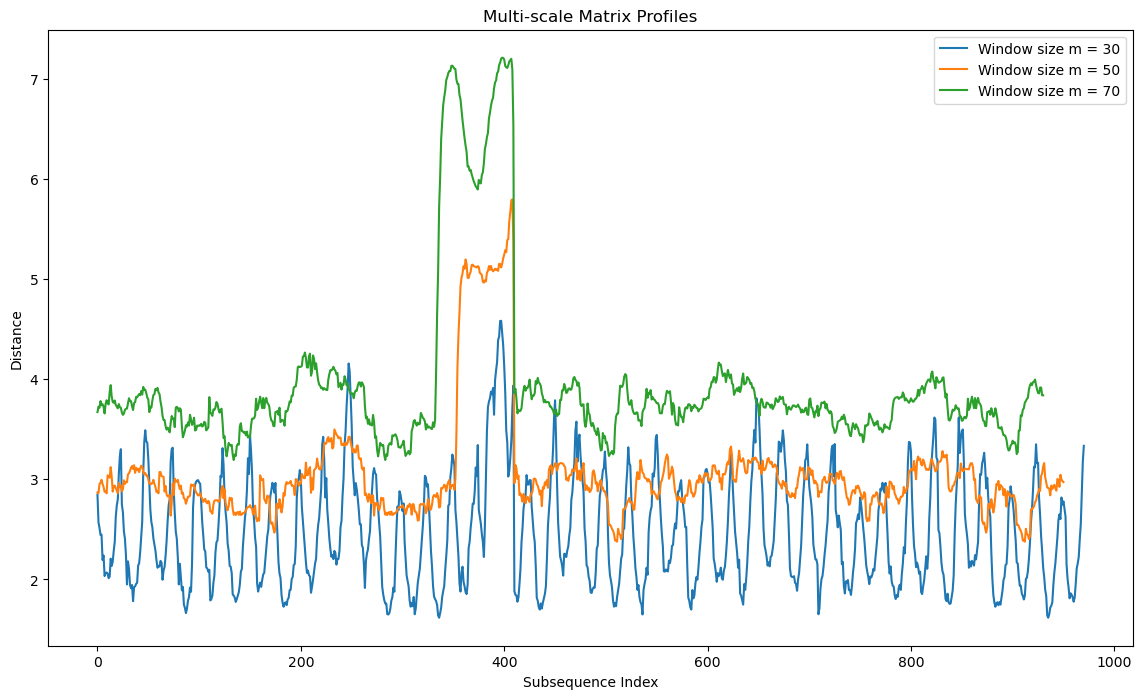

For window size m = 30:
  Motif indices (approx.): [ 85  86  87  88 183 184 186 283 284 285 286 287 288 308 309 310 312 313
 334 335 336 337 338 434 435 436 437 438 508 509 510 535 536 583 584 635
 709 710 838 839 883 884 886 888 934 935 936 937 938]
  Discord indices (approx.): [ 47 150 244 245 246 247 248 249 250 383 384 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 408 409 449 450 470 471 474
 550 646 648 649 650 651 674 822 823 824 847 850 851]
For window size m = 50:
  Motif indices (approx.): [156 157 159 170 171 172 173 174 175 315 316 503 504 505 506 507 508 509
 510 511 512 513 514 515 516 756 757 759 870 871 872 873 874 875 904 905
 906 907 908 909 910 911 912 913 914 915 916 917]
  Discord indices (approx.): [358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 378 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401 402 403 404 405 406 407 408 409]
For window size m = 70:
  Motif indices (approx.

In [ ]:
# -*- coding: utf-8 -*-
"""
Multi-scale Matrix Profile analysis using STUMPY.
This code computes the matrix profile for multiple window sizes (scales)
and visualizes the results to facilitate multi-scale anomaly and motif analysis.
"""

import numpy as np
import matplotlib.pyplot as plt
import stumpy

# 產生模擬時間序列資料
np.random.seed(42)
N = 1000
time = np.arange(N)
data = np.sin(2 * np.pi * time / 50) + 0.3 * np.random.randn(N)
for pos in [400]:
    if pos + 10 < N:
        data[pos:pos+10] += np.linspace(0, 8, 10)

# 定義多個窗口大小作為多尺度參數
window_sizes = [30, 50, 70]  # 可根據資料調整：較小的窗口捕捉局部模式，較大的窗口捕捉全局趨勢

# 為每個尺度計算 Matrix Profile
profiles = {}
for m in window_sizes:
    mp = stumpy.stump(data, m=m)
    profiles[m] = mp[:, 0]

# 畫出多尺度的 Matrix Profile
plt.figure(figsize=(14, 8))
for m in window_sizes:
    profile = profiles[m]
    plt.plot(np.arange(len(profile)), profile, label="Window size m = {}".format(m))
plt.title("Multi-scale Matrix Profiles")
plt.xlabel("Subsequence Index")
plt.ylabel("Distance")
plt.legend()
plt.show()

# 進一步：針對每個尺度設定 motif 與 discord 閥值（例如取5%與95%分位）
for m in window_sizes:
    profile = profiles[m]
    motif_threshold = np.percentile(profile, 5)
    discord_threshold = np.percentile(profile, 95)
    motif_indices = np.where(profile <= motif_threshold)[0]
    discord_indices = np.where(profile >= discord_threshold)[0]
    print("For window size m = {}:".format(m))
    print("  Motif indices (approx.):", motif_indices)
    print("  Discord indices (approx.):", discord_indices)


In [4]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Normal
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#######################################################
# 1. 模型部份：Actor 與 Critic 定義（連續動作版本）
#######################################################

class ContinuousActor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super(ContinuousActor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, action_dim)   # 輸出均值
        self.log_std = nn.Parameter(torch.zeros(action_dim))  # 全局可學習對數標準差

    def forward(self, x):
        # 可以先使用 tanh 或 relu 作為隱藏層激活，兩者都常見
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        mu = self.mu(x)
        std = torch.exp(self.log_std)
        return mu, std

    def get_action(self, state):
        state = torch.FloatTensor(state).to(device)
        mu, std = self.forward(state)
        dist = Normal(mu, std)
        action = dist.sample()
        # PPO 一般做法是不直接對 action 做二次 tanh，這裡以 clamp 限制動作範圍
        # 避免 log_prob 與真實動作不相符
        action_clamped = torch.clamp(action, -2.0, 2.0)
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action_clamped.detach().cpu().numpy(), log_prob.detach()

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size=64):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.value_head = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.value_head(x)

#######################################################
# 2. RL 部份：PPO Agent 定義（含更新與選擇動作邏輯）
#######################################################

class ContinuousPPOAgent:
    def __init__(self, state_dim, action_dim, hidden_size=64, lr=3e-4, epsilon_clip=0.2, gamma=0.99):
        self.actor = ContinuousActor(state_dim, action_dim, hidden_size).to(device)
        self.critic = Critic(state_dim, hidden_size).to(device)
        self.optimizer = optim.Adam(list(self.actor.parameters()) + list(self.critic.parameters()), lr=lr)
        self.epsilon_clip = epsilon_clip
        self.gamma = gamma

    def compute_advantages(self, rewards, values, next_values, dones, lam=0.95):
        advantages = []
        gae = 0
        for i in reversed(range(len(rewards))):
            delta = rewards[i] + self.gamma * next_values[i] * (1 - dones[i]) - values[i]
            gae = delta + self.gamma * lam * (1 - dones[i]) * gae
            advantages.insert(0, gae)
        advantages = np.array(advantages)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        return advantages.tolist()

    def update(self, trajectories, batch_size=64, epochs=10):
        states = torch.FloatTensor(trajectories['states']).to(device)
        actions = torch.FloatTensor(trajectories['actions']).to(device)
        old_log_probs = torch.FloatTensor(trajectories['log_probs']).to(device)
        rewards = trajectories['rewards']
        dones = trajectories['dones']

        with torch.no_grad():
            values = self.critic(states).squeeze().cpu().numpy()
            next_states = torch.FloatTensor(trajectories['next_states']).to(device)
            next_values = self.critic(next_states).squeeze().cpu().numpy()
        
        advantages = self.compute_advantages(rewards, values, next_values, dones)
        advantages = torch.FloatTensor(advantages).to(device)
        targets = advantages + torch.FloatTensor(values).to(device)

        dataset_size = states.size(0)
        for _ in range(epochs):
            for idx in range(0, dataset_size, batch_size):
                batch_slice = slice(idx, min(idx + batch_size, dataset_size))
                batch_states = states[batch_slice]
                batch_actions = actions[batch_slice]
                batch_old_log_probs = old_log_probs[batch_slice]
                batch_advantages = advantages[batch_slice]
                batch_targets = targets[batch_slice]

                mu, std = self.actor(batch_states)
                dist = Normal(mu, std)
                new_log_probs = dist.log_prob(batch_actions).sum(dim=-1)

                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.epsilon_clip, 1 + self.epsilon_clip) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()

                values_pred = self.critic(batch_states).squeeze()
                critic_loss = F.mse_loss(values_pred, batch_targets)

                loss = actor_loss + 0.5 * critic_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def select_action(self, state):
        action, log_prob = self.actor.get_action(state)
        # 需將 log_prob.item()，否則為張量
        return action, log_prob.item()

#######################################################
# 3. Environment 部份：包裝環境並適配新版 Gym 輸出格式
#######################################################

class EnvWrapper:
    """
    包裝 Gym 環境，適配新版 Gym 的 reset() 與 step() 輸出格式。
    """
    def __init__(self, env_name='Pendulum-v1'):
        self.env = gym.make(env_name)
        state, _ = self.env.reset()
        self.state_dim = np.array(state).shape[0]
        self.action_dim = self.env.action_space.shape[0]

    def reset(self):
        state, _ = self.env.reset()
        return state

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        return next_state, reward, done, info

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

#######################################################
# 4. 獎勵重塑與提前終止判定
#######################################################

# 修改後的 is_close_to_zero，只接受兩個參數
def is_close_to_zero(value, tol):
    return abs(value) < tol

# 局部精細獎懲參數（原始定義保持不變，但後續會除以 10 以縮放）
TTOP_XY = [i/1000 for i in range(0, 11)]         # 0, 0.001, …, 0.01
RTOP_XY = [100 - i * 10000 for i in TTOP_XY]        # 從 100 線性下降到 0
TTOP_V  = [i/1000 for i in range(0, 11)]
RTOP_V  = [100 - i * 10000 for i in TTOP_V]

def _adjust_v(v):
    for idx, threshold in enumerate(TTOP_V):
        if is_close_to_zero(abs(v), threshold):
            return RTOP_V[idx] / 10  # 縮放後獎勵
    return 0

# 提前終止判定器：當長時間處於不利狀態時提前終止
class TerminateDetector:
    def __init__(self):
        self.wrong_count = 0
        self.max_wrong = 50  # 當不利步數超過此值時提前終止

    def update(self, x, y, v):
        if x < 0:  # 若在下半部（x < 0）
            self.wrong_count += 1
        else:
            self.reset_wrong()
        if abs(v) > 6:  # 角速度過大
            self.wrong_count += 1

    def reset_wrong(self):
        self.wrong_count = 0

    def is_terminate(self):
        return self.wrong_count > self.max_wrong

def adjust_reward(obs, action, step, td: TerminateDetector):
    # 觀測值：x = cos(theta), y = sin(theta), v = 角速度
    x, y, v = obs[0], obs[1], obs[2]
    # 定義方向：若 y * v < 0，表示正在朝向垂直向上移動（理想方向）
    direction = -1 if (y * v < 0) else 1

    reward = 0

    # 角速度懲罰：若 abs(v) 超過 5，則施加懲罰
    if abs(v) > 5:
        reward -= (abs(v) - 5) * 10

    # 位置誤差：理想狀態為 x→1, y→0
    pos_error = abs(1 - x) + abs(y)
    if pos_error < 0.2:
        reward += (0.2 - pos_error) * 50

    # 若擺錘處於下半部 (x < 0)
    if x < 0:
        if direction > 0:
            reward -= 10
        if step > 150:
            reward -= 0.05 * step
    else:
        # 局部高精度獎勵：當位置非常接近目標（x≈1, y≈0）
        for idx, threshold in enumerate(TTOP_XY):
            if is_close_to_zero(1 - x, threshold) and is_close_to_zero(y, threshold):
                if direction < 0:
                    reward += RTOP_XY[idx] / 10  # 局部位置獎勵
                    reward += _adjust_v(v)         # 角速度獎勵（低角速度好）
                break
        # 當完美對齊時（x≈1, y≈0, v≈0），給予額外獎勵
        if is_close_to_zero(1 - x, 1e-3) and is_close_to_zero(y, 1e-3) and is_close_to_zero(v, 1e-3):
            reward += 100

    # 更新提前終止判定器
    td.update(x, y, v)
    terminated = td.is_terminate()
    if terminated:
        return -50, True  # 若提前終止，懲罰改為 -50
    return reward, False

#######################################################
# 5. 訓練部份：Trainer 封裝訓練流程（整合獎勵重塑）
#######################################################

class PPOTrainer:
    def __init__(self, agent, env_wrapper, max_steps_per_episode=200, num_episodes=500):
        self.agent = agent
        self.env = env_wrapper
        self.max_steps = max_steps_per_episode
        self.num_episodes = num_episodes
        self.td = TerminateDetector()  # 終止判定器

    def train(self):
        for episode in range(self.num_episodes):
            state = self.env.reset()
            trajectories = {
                'states': [],
                'actions': [],
                'log_probs': [],
                'rewards': [],
                'next_states': [],
                'dones': []
            }
            episode_reward = 0

            for step in range(self.max_steps):
                action, log_prob = self.agent.select_action(state)
                next_state, _, done, _ = self.env.step(action)
                custom_reward, custom_term = adjust_reward(state, action, step, self.td)
                if custom_term:
                    done = True
                episode_reward += custom_reward

                trajectories['states'].append(state)
                trajectories['actions'].append(action)
                trajectories['log_probs'].append(log_prob)
                trajectories['rewards'].append(custom_reward)
                trajectories['next_states'].append(next_state)
                trajectories['dones'].append(float(done))

                state = next_state
                if done:
                    break

            self.agent.update(trajectories)
            if (episode+1)%20 == 0:
                print(f"Episode {episode+1}: Reward = {episode_reward}")
            self.td.reset_wrong()

#######################################################
# 6. 主程式：組合各部件並執行訓練
#######################################################

if __name__ == '__main__':
    env_name = 'Pendulum-v1'
    env_wrapper = EnvWrapper(env_name)
    
    state_dim = env_wrapper.state_dim
    action_dim = env_wrapper.action_dim

    # 根據 Pendulum 任務調整超參數（如有需要再微調）
    agent = ContinuousPPOAgent(state_dim, action_dim, hidden_size=64, lr=3e-4, epsilon_clip=0.2, gamma=0.99)
    trainer = PPOTrainer(agent, env_wrapper, max_steps_per_episode=200, num_episodes=4000)

    trainer.train()
    env_wrapper.close()


c:\Users\jhbai\Anaconda\envs\MachineLearningEnv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 20: Reward = -320
Episode 40: Reward = -310
Episode 60: Reward = -300
Episode 80: Reward = -280
Episode 100: Reward = -260
Episode 120: Reward = -340.0529479980469


C:\Users\jhbai\AppData\Local\Temp\ipykernel_35636\2622217880.py:114: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(values_pred, batch_targets)


Episode 140: Reward = -290
Episode 160: Reward = -320
Episode 180: Reward = -1398.3552512452006
Episode 200: Reward = -641.8897771835327
Episode 220: Reward = -314.55623149871826
Episode 240: Reward = -282.3253917694092
Episode 260: Reward = -661.446361541748
Episode 280: Reward = -338.7063694000244
Episode 300: Reward = -1526.6411762237549
Episode 320: Reward = -1679.0788798151536
Episode 340: Reward = -290
Episode 360: Reward = -1800.1005633141845
Episode 380: Reward = -260
Episode 400: Reward = -1756.2952033534646
Episode 420: Reward = -1388.8839546203615
Episode 440: Reward = -250
Episode 460: Reward = -641.9511127471924
Episode 480: Reward = -450.44265270233154
Episode 500: Reward = -402.4956703186035
Episode 520: Reward = -290
Episode 540: Reward = -338.41881275177
Episode 560: Reward = -2568.2070306144656
Episode 580: Reward = -2278.055102717876
Episode 600: Reward = -2344.1419354485347
Episode 620: Reward = -2086.996630274225
Episode 640: Reward = -1933.8634709344246
Episode 66

KeyboardInterrupt: 

GIF 已保存為 Pendulum.gif


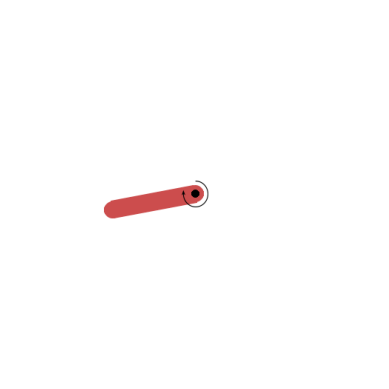

In [5]:
import gym
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter, FuncAnimation
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 建立環境
ENV = gym.make("Pendulum-v1", render_mode="rgb_array")
state, _ = ENV.reset()
frames = []  # 用於存儲每個畫面

# 遊戲過程
done = False
for f in range(200):
    action, log_prob = agent.select_action(state)
    state, reward, done, _, _ = ENV.step(action)
    frame = ENV.render()  # 獲取畫面陣列
    frames.append(frame)  # 儲存畫面

ENV.close()

# 創建 GIF
fig, ax = plt.subplots()
ax.axis('off')  # 關閉座標軸
img = ax.imshow(frames[0])  # 初始化第一幀

# 更新每幀的函數
def update(frame):
    img.set_data(frame)
    return [img]

# 使用 matplotlib.animation 生成動畫
ani = FuncAnimation(
    fig, update, frames=frames, interval=50, blit=True  # interval: 控制幀率
)

# 將動畫保存為 GIF
ani.save("Pendulum.gif", writer=PillowWriter(fps=20))  # fps: 每秒幀數
print("GIF 已保存為 Pendulum.gif")

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import threading
import queue
import time

# 定義一個特殊物件作為 sentinel，通知 consumer 生產工作已結束
_SENTINEL = object()

def producer(produce_func, param_list, output_queue):
    """
    Producer 函式：
    依據 param_list 中的每一個字典參數，呼叫 produce_func 並將結果放入 output_queue。
    """
    for params in param_list:
        # 使用 dictionary 解包傳入參數（例如查詢資料或 IO 作業）
        result = produce_func(**params)
        # 將結果放入 Queue 中，供 consumer 取得
        output_queue.put(result)
        print(f"[Producer] 已放入結果: {result}")
    # 完成所有工作後，放入 sentinel 以通知 consumer 生產結束
    output_queue.put(_SENTINEL)
    print("[Producer] 所有工作完成，已放入 sentinel。")

def consumer(consume_func, param_list, input_queue):
    """
    Consumer 函式：
    根據 param_list 中的每一個字典參數，不斷從 input_queue 中取得結果，
    並呼叫 consume_func 處理該結果與參數組合。
    """
    for params in param_list:
        # 從 Queue 中取得一筆結果（此操作會阻塞直到有資料進入）
        result = input_queue.get()
        # 檢查是否為 sentinel，若是則代表沒有更多資料要處理
        if result is _SENTINEL:
            print("[Consumer] 收到 sentinel，結束消費。")
            break
        # 呼叫 consumer 的工作函式，將取得的結果與參數傳入
        consume_func(result, **params)
        print(f"[Consumer] 處理完成: {result} 使用參數 {params}")
    # 若 sentinel 不是在 for 迴圈最後一個參數取得，則需確保隊列中沒有殘留資料
    while True:
        try:
            result = input_queue.get_nowait()
            if result is _SENTINEL:
                break
            consume_func(result, **params)
        except queue.Empty:
            break

def run_consumer_producer(producer_func, producer_params, consumer_func, consumer_params):
    """
    主程式函式：
    建立 Queue 與兩個線程，分別運行 producer 與 consumer，並等待其完成。
    """
    # 建立 Queue 作為 producer 與 consumer 間的通訊管道
    q = queue.Queue()

    # 建立 producer 與 consumer 線程，將各自的函式與參數傳入
    producer_thread = threading.Thread(target=producer, args=(producer_func, producer_params, q))
    consumer_thread = threading.Thread(target=consumer, args=(consumer_func, consumer_params, q))

    # 啟動線程
    producer_thread.start()
    consumer_thread.start()

    # 等待兩個線程都完成工作
    producer_thread.join()
    consumer_thread.join()
    print("[Main] Producer 與 Consumer 都已完成。")

# 範例：定義一個模擬 Producer 的工作函式
def sample_producer_task(query, delay):
    """
    模擬一個資料查詢或 IO 操作：
    參數 query 為查詢內容，delay 為模擬等待時間。
    """
    time.sleep(delay)  # 模擬耗時作業
    result = f"查詢結果：{query}"
    print(f"[sample_producer_task] 完成查詢：{query}")
    return result

# 範例：定義一個模擬 Consumer 的工作函式
def sample_consumer_task(result, process_flag):
    """
    模擬對 producer 回傳結果的處理：
    process_flag 為處理標記，根據此標記可作不同的後續處理。
    """
    # 這裡可以加入進一步的處理邏輯，示範將結果標記後輸出
    if process_flag:
        processed_result = f"{result} - 處理後資料"
    else:
        processed_result = f"{result} - 原始資料保留"
    print(f"[sample_consumer_task] 處理結果: {processed_result}")

if __name__ == "__main__":
    # 設定 producer 的參數列表，每一個 dictionary 包含查詢內容與延遲時間
    producer_params_list = [
        {"query": "資料庫查詢 1", "delay": 1},
        {"query": "資料庫查詢 2", "delay": 2},
        {"query": "資料庫查詢 3", "delay": 1.5}
    ]

    # 設定 consumer 的參數列表，每一個 dictionary 包含處理標記
    consumer_params_list = [
        {"process_flag": True},
        {"process_flag": False},
        {"process_flag": True}
    ]

    # 執行 producer-consumer 架構，開始工作
    run_consumer_producer(sample_producer_task, producer_params_list, sample_consumer_task, consumer_params_list)


[sample_producer_task] 完成查詢：資料庫查詢 1
[Producer] 已放入結果: 查詢結果：資料庫查詢 1
[sample_consumer_task] 處理結果: 查詢結果：資料庫查詢 1 - 處理後資料
[Consumer] 處理完成: 查詢結果：資料庫查詢 1 使用參數 {'process_flag': True}
[sample_producer_task] 完成查詢：資料庫查詢 2
[Producer] 已放入結果: 查詢結果：資料庫查詢 2
[sample_consumer_task] 處理結果: 查詢結果：資料庫查詢 2 - 原始資料保留
[Consumer] 處理完成: 查詢結果：資料庫查詢 2 使用參數 {'process_flag': False}
[sample_producer_task] 完成查詢：資料庫查詢 3
[Producer] 已放入結果: 查詢結果：資料庫查詢 3
[Producer] 所有工作完成，已放入 sentinel。
[sample_consumer_task] 處理結果: 查詢結果：資料庫查詢 3 - 處理後資料
[Consumer] 處理完成: 查詢結果：資料庫查詢 3 使用參數 {'process_flag': True}
[Main] Producer 與 Consumer 都已完成。
